This Jupyter notebook contains the code to perform simulations for the mini project at C6.5 Theories of Deep Learning 

In [44]:
## Inital Setup

In [45]:
import tensorflow as tf
import random
import copy
import matplotlib.pyplot as plt
import time
from gsam import GSAM 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.datasets import mnist

For the first test we will use the scikit learn 2 moons dataset to demonstrate the differences between GSAM and Adaptive-GSAM performance.

In [46]:
data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# Ensure the labels are one-hot encoded
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


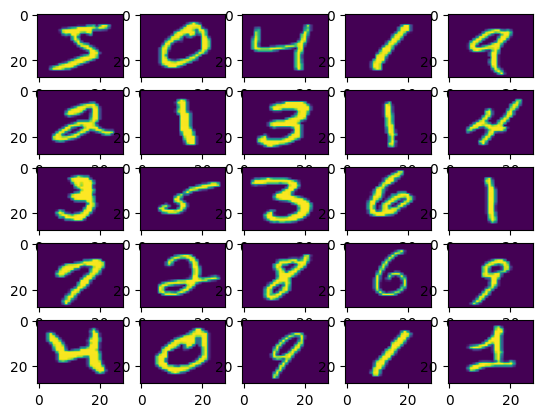

In [47]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1

plt.show()

We use an overparamaterised ReLU network

In [48]:
# Define the model



model = Sequential([
    # Convolutional layer
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),  # Max-pooling layer
    # Another convolutional layer
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    # Flattening layer
    Flatten(),
    # Fully connected layer
    Dense(128, activation="relu"),
    # Output layer
    Dense(10, activation="softmax")
])

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Here we create a function for training

In [49]:



# Training function
def train_model_with_gsam(model, use_gsam=True):
    # Create the GSAM model if specified
    if use_gsam:
        gsam_model = GSAM(model, adaptive = True)
    else:
        gsam_model = GSAM(model, adaptive = False)
    
    gsam_model.compile(
        optimizer='SGD',  # You can use the standard SGD or any optimizer you want
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print the total learnable parameters in millions
    print(f"Total learnable parameters: {gsam_model.model.count_params() / 1e6} M")

    # Train the model
    start = time.time()
    history = gsam_model.fit(
        x_train, y_train, epochs=25, batch_size=32, 
        validation_data=(x_test, y_test), 
    )

    # Evaluate the model on the test set
    test_loss, test_acc = gsam_model.evaluate(x_test, y_test)

    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")
    print(f"Total training time: {(time.time() - start) / 60.} minutes")

    return history

Now we train two models, one with vanilla GSAM and one with adaptive GSAM

In [50]:
# Training with GSAM(False)
print("Training with Vanilla-GSAM...")
history_gsam_vanilla = train_model_with_gsam(copy.deepcopy(model),False)

print("Training with Adaptive-GSAM...")
history_gsam_adaptive = train_model_with_gsam(copy.deepcopy(model),True)






Training with Vanilla-GSAM...
Total learnable parameters: 0.225034 M
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.1561 - loss: 0.1000 - val_accuracy: 0.7413 - val_loss: 0.1905
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8650 - loss: 0.1000 - val_accuracy: 0.6836 - val_loss: 0.3012
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9152 - loss: 0.1000 - val_accuracy: 0.6396 - val_loss: 0.3923
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9284 - loss: 0.1000 - val_accuracy: 0.5889 - val_loss: 0.4768
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9333 - loss: 0.1000 - val_accuracy: 0.6577 - val_loss: 0.5205
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9431 - loss: 0.1000 - val_accuracy: 0.5782 - val_loss: 0.5486
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9469 - loss: 0.1000 - val_accuracy: 0.6179 - val_loss: 0.5752
Epoch 8

Now we plot a comparison between the two models

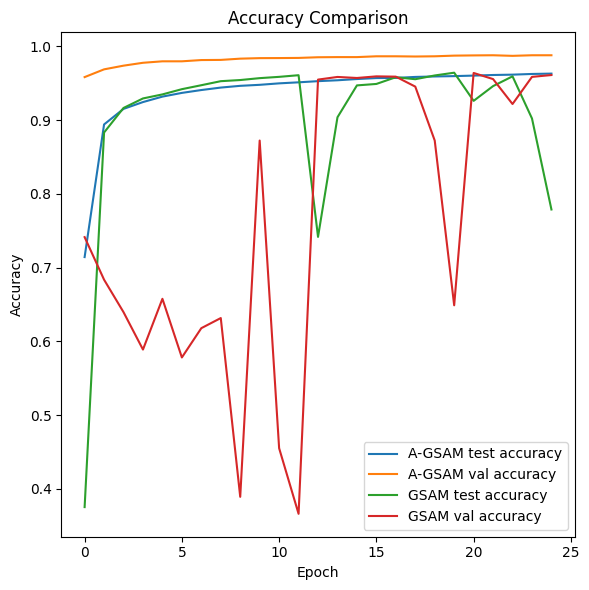

In [51]:
plt.figure(figsize=(6, 6))

# Accuracy Plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.plot(history_gsam_adaptive.history['accuracy'][:], label='A-GSAM test accuracy')
plt.plot(history_gsam_adaptive.history['val_accuracy'][:], label='A-GSAM val accuracy')
plt.plot(history_gsam_vanilla.history['accuracy'][:], label='GSAM test accuracy')
plt.plot(history_gsam_vanilla.history['val_accuracy'][:], label='GSAM val accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()